# Example workflow of process sensitivity analiysis using 1D groundawter flow model 

This jupyter file applies Variance-Based Sensitivity Analysis to a one-dimensional groundwater flow model revised after Dai et al. (2017). An unconfined aquifer with a length $L=10,000$ m is adjacent to two constant head boundaries and a uniform precipitation infiltrates to the top of the aquifer. The aquifer is under steady state condition and the groundwater discharge per unit width at the location $x_0 = 7,000$ m is our quantity of interest. The hydrological model is quite simple and the groundwater discharge per unit width can be analytically solved so it is computationally affordable for the Monte Carlo simulation. For more detials about the model settings, readers are reffered to Yang et al. (2020).

Prepared by Jing Yang and Ming Ye at Florida State University, 2020. Mail to: mye@fsu.edu.



## 1. load basic modules

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

import sammpy as sm
import vbsa as vb

plt.style.use('ggplot')

## 2. Define process model functions

### 2.1 Recharge process

Two rainfall recharge models ($R_1$ and $R_2$) are used to simulate the recharge process that converts precipitation $[inch·yr^{-1}]$ to groundwater recharge $[m·d^{-1}]$, and they are:  

$$R_1:w=a\times(P-14)^{0.5}\times25.4\times0.001\div365$$  

$$R_2:w=b\times(P-15.7)\times25.4\times0.001\div365$$

where a and b are scaling parameters which are assumed to follow the normal distribution, N(2.0, 0.4), and the uniform distribution, U(0.2, 0.5), respectively; P is the annual precipitation which is set to be a constant of 60 $[inch·yr^{-1}]$. 

In [2]:
# process model: rechrg_lin
@nb.njit
def rechrg_lin_func(P, a):
    """
    Compute recharge[m/d] using recharge model R1 by Chaturvedi(1936)
    
    """
    return a * (P - 14)**0.5 * 25.4 * 0.001 / 365

# process model: rechrg_power
@nb.njit
def rechrg_power_func(P, b):
    """
    Compute recharge[m/d] using recharge model R2 by Krishna Rao (1970)
    
    """
    return b * (P - 15.7) * 25.4 * 0.001 / 365

### 2.2 Geology process

Hydraulic conductivity (K) $[m·d^{-1}]$ over the domain is parameterized by two geology process models, i.e., a single layer model(G1) and a double layer model(G2): 

$$G_1:K=K_1=K_2$$  

$$G_2=
\begin{cases}
K_1 & \text{for x < 7000m}\\
K_2 & \text{for x >= 7000m}
\end{cases}$$

In model $G_1$, the aquifer is assumed to be homogeneous and the hydraulic conductivity follows the lognormal distribution, LN(2.9, 0.5). Model $G_2$ is parametrized into two zones at the location of $x_0=7000$. The hydraulic conductivity $K_1$ of zone 1 (x<7000 m) and $K_2$ of zone 2 (x >= 7000 m) are assumed to follow the lognormal distributions, LN(2.6, 0.3) and LN(3.2, 0.3), respectively. 

In [3]:
# process model: geol_single
@nb.njit
def geol_single_func(K):
    """
    Single layer geological model
    
    """
    return K, K

# process model: geol_double
@nb.njit
def geol_double_func(K1, K2):
    """
    Double layer geological model
    
    """
    return K1, K2

### 2.3 Snowmelt process

Assuming there is no gauge station at the river thus the river stage $h_2$ is unknown. An empirical rating curve function is used to covert the discharge into river stage:
$$h_2=0.3\times Q^{0.6}+289$$  
where $Q$ denotes the river discharge $[m^3·s^{-1}]$ which can be calculated form the snowmelt runoff process at the upstream catchment: 
$$Q=C_{sn}\times M\times SVC \times A \times \frac{0.001}{86400}$$
where $C_{sn}$ denotes the runoff coefficient expressing the losses as a ratio; M is the snow melt rate $[mm·d^{-1}]$; SVC is the ration of snow-covered area to the total area; A is the area of the upper catchment $[m^2]$; 0.001/86400 is the conversion factor from $[m·d^{-1}]$ to $[m^3·s^{-1}]$. Fixed values $C_{sn} = 0.8$, $SVC = 0.7$ and $A = 2000$ $km^2$ are used to characterize the upstream catchment conditions. Thus, the only unknown factor is the snowmelt rate, M. Two different snowmelt functions, i.e., degree-day method and restricted degree-day radiation balance approach (Hock 2003, Kustas et al. 1994), are used to evaluate the daily snow melt depth [mm]:
$$M_1:M=f_1\times(T_a-T_m)$$
$$M_2:M=f_2\times(T_a-T_m)+r\times R_n$$

where $f_1$ and $f_2$ $[mm·℃^{-1}·d^{-1})$ are snowmelt factors, which are assumed to follow norm distributions, N (3.5, 0.75) and U[2.5, 0.3], respectively. ${T_a}$ [℃] is the average temperature for a given day and $T_m$ [℃] is the temperature threshold when snow melt occurs which is typically set to be 0. The second equation consider the effects of surface radiation budget, $R_n [W·m^{-2}]$, using a conversion factor r for converting energy flux density to snowmelt depth. The $r [mm·d^{-1}·(W·m^{-2})^{-1}]$ is assumed to follow normal distribution, N(0.3, 0.05). $T_a$ and $R_n$ are set to be 7 ℃ and 80 $W·m^{-2}$ respectively in this case. 

In [4]:
# process model: snomlt_degree
@nb.njit
def snomlt_degree_func(Ta, Tm, Csn, SVC, A, z0, f1):
    """
    Compute river stage h2 [m] using degree-day method
 
    """
    M = f1 * (Ta - Tm)
    Q = Csn * M * SVC * A * 0.001 / 86400
    
    return 0.3 * Q**0.6 + z0

# process model: snomlt_restrcd
@nb.njit
def snomlt_restrcd_func(Ta, Tm, Csn, Rn, SVC, A, z0, f2, r):
    """
    Compute river stage h2 [m] using degree-day method
 
    """
    M = f2 * (Ta - Tm) + r * Rn
    Q = Csn * M * SVC * A * 0.001 / 86400
    
    return 0.3 * Q**0.6 + z0

## 3. Define the system model function

The analytical solution for the groundwater discharge per unit width at a given location x, $q(x)$, can be obtained from:

$$q(x)=K_1\frac{h_1^2-h_2^2}{2(x_0-\lambda x_0+\lambda L)}-\frac{1}{2}w\frac{x_0^2-\lambda x_0^2+\lambda L^2}{x_0-\lambda x_0+\lambda L} + wx$$

where $\lambda=K_1/K_2$.

In [5]:
# system model
@nb.njit
def dschrg_func(x0, L, h1, w, K1, K2, h2):
    """
    Compute discharge per unit [m2/d] at x=x0 using anaytical solution
    
    """
    lamda = K1 / K2
    
    return K1 * (h1**2 - h2**2) / (2 * (x0 - lamda * x0 + lamda * L)) - 1/2 * w * (x0**2 - lamda * x0**2 + lamda * L**2) / (x0 - lamda * x0 + lamda * L) + w * x0


## 4. Generate ouputs with parametric and process model uncertainty

### 4.1 Define the model frames

In [6]:
# Number of sample realizations
N = 100

# System model class
model = sm.model()
model.name = 'gwmodel'
model.frames = {'names'  : ['rechrg', 'geol', 'snomlt'],
                'options': [['rechrg_lin', 'rechrg_power'], 
                            ['geol_single', 'geol_double'],
                            ['snomlt_degree', 'snomlt_restrcd']],
                'weights': [[0.5, 0.5], 
                            [0.5, 0.5],
                            [0.5, 0.5]]}
# Constant variables used in the simulations
model.env = {'x0'    : 7000,
             'L'     : 10000,
             'h1'    : 300,
             'P': 60,
             'Ta'    : 7,
             'Tm'    : 0,
             'Csn'   : 0.8,
             'SVC'   : 0.7,
             'A'     : 2000 * 1e6,
             'z0'    : 289,
             'Rn'    : 80}

# Random variabs used in the simulation
model.pars = {'names': ['a', 'b', 'K', 'K1', 'K2', 'f1', 'f2', 'r'],
              'bounds':[[2.0, 0.4], [0.2, 0.5], [2.9, 0.5], [2.6, 0.3], [3.2, 0.3], [3.5, 0.75], [2.5, 0.3], [0.3, 0.05]],
              'dists': ['norm', 'unif', 'lognorm', 'lognorm', 'lognorm', 'norm', 'norm', 'norm']}

# system model functions 
model.func = dschrg_func

### 4.2 Generate the parameter realizations 

The samples are genertaed using SALib with Saltelli's sampling scheme. Saltelli's scheme extends the Sobol sequence in a way to reduce the error rates in the resulting sensitivity index calculations. For more detials, readers are refered to https://salib.readthedocs.io/en/latest/index.html#. The generated parameter values can be visualized using histograms.

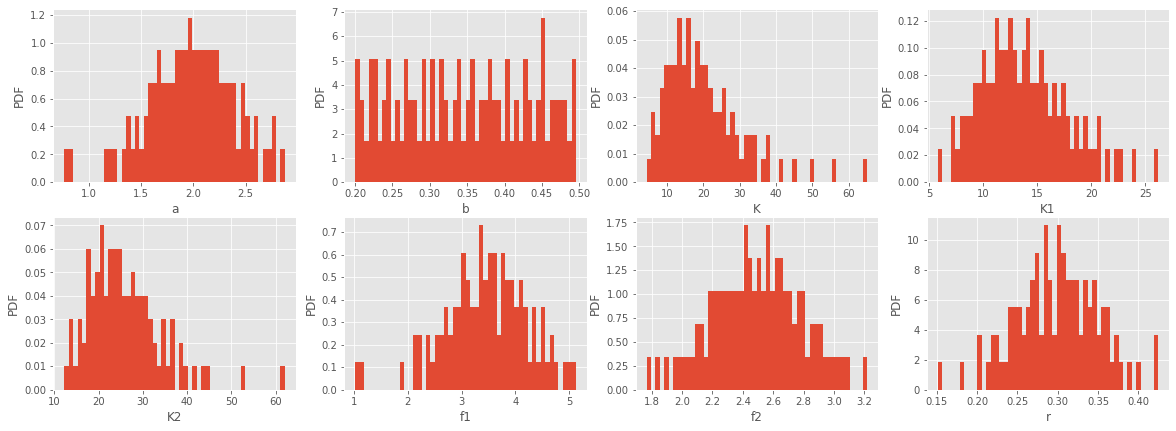

In [28]:
param_values = model.sample(nobs=N, seed=933090936)

import hist

hist.histplot(model, param_values)

### 4.3 Generate the outputs

The outputs are generated using considering both parametric and process model uncertainty. The outputs are stored in an array of whihc the size is 2 x N x 2 x N x 2 x N in this case, corresponding to the two recharge process models and their N parameter realizaitons, the two geology process models and their N parameter realizations, and the two snowmelt process models and their N parameter realizations, respectively. The advantage of storing data in this way is we can compute all the varianced-based sensitivy indices including the first-order, total-effect, second-order and higher-order ones of all processes using this array. The disadvantage is storing such a array requirs a large memory size since it is high demensional.  

In [8]:
# Retrive the costant parameter values
Ma = len(model.frames['options'][0])          # Number of alterantive models for recharge process
Mb = len(model.frames['options'][1])          # Number of alterantive models for geloogy process
Mc = len(model.frames['options'][2])          # Number of alterantive models for snow melt process

x0  = model.env['x0'] 
L   = model.env['L'] 
h1  = model.env['h1']
P   = model.env['P']
Ta  = model.env['Ta']
Tm  = model.env['Tm']
Csn = model.env['Csn']
SVC = model.env['SVC']
A   = model.env['A']
z0  = model.env['z0']
Rn  = model.env['Rn']

# Calculate model outputs using numba to accelerate 
@nb.njit(parallel=True, fastmath=True)
def cmpt_Dscs():
    # Initilize an array
    Y = np.zeros((Ma, N, Mb, N, Mc, N))
    
    for i in range(Ma):
        for j in nb.prange(N):
            if i == 0:
                a = param_values[j, 0]
                w = rechrg_lin_func(P, a)
            else:
                b = param_values[j, 1]
                w = rechrg_power_func(P, b)
                
            for k in range (Mb):
                for l in nb.prange(N):
                    if k == 0:
                        K = param_values[l, 2]
                        K1, K2 = geol_single_func(K)
                    else:
                        K1 = param_values[l, 3]
                        K2 = param_values[l, 4]
                        K1, K2 = geol_double_func(K1, K2)
                        
                    for m in range(Mc):
                        for n in nb.prange(N):
                            if m == 0:
                                f1 = param_values[n, 5]
                                h2 = snomlt_degree_func(Ta, Tm, Csn, SVC, A, z0, f1)
                            else:
                                f2 = param_values[n, 6]
                                r =  param_values[n, 7]
                                h2 = snomlt_restrcd_func(Ta, Tm, Csn, Rn, SVC, A, z0, f2, r)

                            Y[i, j, k, l, m, n] =  dschrg_func(x0, L, h1, w, K1, K2, h2)
                            
    return Y
                
Y = cmpt_Dscs()

## 5. Process sensitivity analysis

The sensitivity of the parameters under individual system model can be performed using many sensitivity analysis tools such as SALib thus it is not shown here. Below, we use the model outputs generated in the last step to evaluate the process sensitivity by using both variance-based method and the difference-based method.

### 5.1 Sensitivity analysis using variance-based method

By decomposing the variance, the first-order process sensitivity index is defined by Dai et al. (2017) as

$$PS_K=\frac{V_{M_K}(E_{M_{\sim K}}[\Delta|M_K])}{V(\Delta)}$$

The total effect process sensitivty index is defined by Yang et al. (2020) as

$$PS_{TK}=\frac{E_{M_{\sim K}}(V_{M_{K}}[\Delta|M_{\sim K}])}{V(\Delta)}$$

The sensitivy indices including ones of both first-order and total effect can be computed using the function of vbsa.analysis. The function takes the model object and output values as input parameters and return a dictionary with keys "PSK" and "PSTK",  corresponding to the first-order and total effect process sensitivty index, respectively. Each entry is a array of size of the number of process. The "print_to_console" is used to control the dispaly of the computing information.

In [9]:
Ret = vb.analysis(model, Y, print_to_console=True)

100
Runing first-order process sensitivy analysis...
Runing total effect process sensitivy analysis...
Process 	 PSK 	 PSTK
rechrg 	 0.1460 	 0.1495
geol 	 0.0660 	 0.2074
snomlt 	 0.6466 	 0.7845


The first-order and total effect process sensitivity indices of the three processes is 14.60%, 6.60%, and 64.66%, 14.95%, 20.74% and 78.45%, respectivly.The results can be visualized using the bar plots.

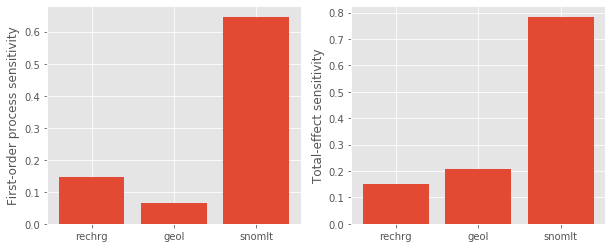

In [10]:
from bar import plot
plot(model, Ret)

### 5.2 Sensitivity analysis using difference-based method

The purpose of the sensitivity analysis using difference-based method is very similar to the total effect-process senistivity analysis,that is to screen the non-influential processes to simplify the model.Inspired by the Morris elementary effect, the mean and variance of the absolute output difference caused by the variation (uncertainty) of a process K when the other process are fixed can be used to measure the sensitivity of this process:

$$E(d\Delta|K)=E_{\sim K}E_{P_K}(d\Delta|\sim K)\\
 \qquad\qquad\,\,=E_{M_{\sim K}}E_{P_{M_K}}(d\Delta|M_{\sim K})$$
 
 $$V(d\Delta|K)=E_{\sim K}V_{P_K}(d\Delta|\sim K)+ V_{\sim K}E_{P_K}(d\Delta|\sim K)\\
 \qquad\qquad\,\,\,\,\,\,\,\,=E_{M_{\sim K}}V_{P_{M_K}}(d\Delta|M_{\sim K}) + V_{M_{\sim K}}E_{P_{M_K}}(d\Delta|M_{\sim K})$$
 
                                                                       

In [11]:
import mmds as md

Ret = md.analysis(model, Y, print_to_console=True)

Runing difference-based process sensitivy analysis...
Process 	 mean 	 variance
rechrg 	 0.6234 	 0.2252
geol 	 0.6554 	 0.4218
snomlt 	 1.3097 	 1.5059
Runing difference-based process sensitivy analysis...
Process 	 mean 	 variance
rechrg 	 0.6234 	 0.2252
geol 	 0.6554 	 0.4218
snomlt 	 1.3097 	 1.5059


The mean and variance of the output difference of the three processes is 0.6234, 0.6554, and 1.3097, 0.2252, 0.4218, and 1.5059 respectivly.The results can be visualized using the scatter plot.

In [24]:
from scatter import plot
plot(model, Ret)

NameError: name 'plt' is not defined